# Objective: To identify the driving factors behind the loan default (i.e. the variables which are strong indicators of default) to minimize the financial loss.

* We will be following Exploratory Data Analysis approach to get the insights.

In [1]:
#importing liabraries:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data sourcing
### Reading 'loan' csv file:
* Following dataset only contains the transactions where the loan was sanctioned i.e. it doesnt have records where loan was denied.
* It contains the complete loan data for all loans issued through the time period 2007 t0 2011.

In [2]:
"""Dataset has large number of columns with mixed data types. Pandas raises a warning as it tries to guess 
   dtype of each column which is enefficient. We can either load entire data using unicode encoding and 
   manually set each datatype. But we will be loading dataset with encoding = "ISO-8859-1 and 
   low_memory set to 'False' since dataset size is not that large"""
pass

In [3]:
df = pd.read_csv(r'C:\Users\ADMIN\Downloads\loan.csv',encoding = "ISO-8859-1",parse_dates=True ,low_memory=False)

In [4]:
#Returns a list of column/attribute names having same value in every row:
def list_col_with_constant_val(dataframe):
    col_with_same_val = []
    for col in list(dataframe.columns):
        if len(dataframe[col].unique()) == 1:
            col_with_same_val.append(col)
    return col_with_same_val    

In [5]:
#Handles invalid years ==> e.g. converts year '2067' to '1967'
def format_year(x):
    if x <= 2012:
        x = x
    else:
        x = x - 100
    return x

In [6]:
#Transforms employee serve period values from 'str' to corresponding 'numbers' so binning is achievable:
def format_emp_length(x):
    if '<' in x:
        return 0
    elif '+' in x:
        return 10
    else:
        return int(x[0])

In [7]:
#Creating a function to plot a bar diagram for the purpose of reusability:
def categorical_plot(attribute,xticks = 0):
    df[attribute].value_counts().plot.bar(figsize=[10,8])
    plt.xlabel(attribute)
    plt.ylabel('frequency')
    plt.title(f'{attribute} vs frequency')
    if xticks ==0:
        plt.xticks(rotation = 0)
    else:
        plt.xticks(rotation = 90)
    plt.grid()
    plt.show()

In [8]:
#Creating a function to plot a box diagram for the purpose of reusability:
def box_plot(attribute,y_log=False):
    plt.figure(figsize=(8,5))
    sns.boxplot(y=attribute, data=df)
    if y_log:
        plt.ylabel(f"{attribute} in log scale")
        plt.yscale('log')
    plt.title(f'{attribute} distribution')
    plt.show()

In [9]:
#Creating a function to plot a bar diagram for bivariate analysis:
def default_rate_barplot(attribute,target='loan_status',orient = 'v',rot=0,level_2=None,col_palette=None):
    if level_2==None:
        temp = df.groupby(attribute)[target].value_counts().unstack()
        temp['default rate'] = temp['Charged Off']*100/(temp['Charged Off']+temp['Fully Paid'])
        temp=temp.reset_index()
    else:
        temp = df.groupby([attribute,level_2])[target].value_counts().unstack()
        temp['default rate'] = temp['Charged Off']*100/(temp['Charged Off']+temp['Fully Paid'])
        temp=temp.reset_index()
    if orient == 'v':
        if rot == 90:
            plt.xticks(rotation=90)
        fig = sns.barplot(x=attribute,y='default rate',data=temp,hue=level_2,palette=col_palette)
    else:
        fig = sns.barplot(x='default rate',y=attribute,data=temp,hue=level_2,palette=col_palette)
    plt.title(f'{attribute} against default rate')
    return fig

In [10]:
#Setting options to displays all the columns of dataframe,displaying them and then reseting the parameters to default
def verbosed(df):
    import pandas as pd
    pd.set_option('display.max_rows', 2)
    pd.set_option('display.max_columns', len(df.columns))
    print(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [11]:
df.shape

(39717, 111)

In [12]:
verbosed(df)

            id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0      1077501    1296599       5000         5000           4975.0   
...        ...        ...        ...          ...              ...   
39716    87023      86999       7500         7500            800.0   

             term int_rate  installment grade sub_grade         emp_title  \
0       36 months   10.65%       162.87     B        B2               NaN   
...           ...      ...          ...   ...       ...               ...   
39716   36 months   13.75%       255.43     E        E2  Evergreen Center   

      emp_length home_ownership  annual_inc verification_status issue_d  \
0      10+ years           RENT     24000.0            Verified  Dec-11   
...          ...            ...         ...                 ...     ...   
39716   < 1 year            OWN     22000.0        Not Verified  Jun-07   

      loan_status pymnt_plan  \
0      Fully Paid          n   
...           ...        ...   
39716  Fully 

In [13]:
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39717 non-null  int64  
 1   member_id                       39717 non-null  int64  
 2   loan_amnt                       39717 non-null  int64  
 3   funded_amnt                     39717 non-null  int64  
 4   funded_amnt_inv                 39717 non-null  float64
 5   term                            39717 non-null  object 
 6   int_rate                        39717 non-null  object 
 7   installment                     39717 non-null  float64
 8   grade                           39717 non-null  object 
 9   sub_grade                       39717 non-null  object 
 10  emp_title                       37258 non-null  object 
 11  emp_length                      38642 non-null  object 
 12  home_ownership                 

In [14]:
#As per our objective our target variable is loan_status. 
df.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

In [15]:
"""Since some clients (which are labelled 'Current') are still in the process of paying the instalments,
   these will not be helpful for deciding driving variables as they can not be termed as defaulters yet.
   Thus filtering 'current' customers"""

df = df[df.loan_status.isin(['Fully Paid','Charged Off'])]
df.shape

(38577, 111)

# Data cleaning 
### Handling missing values, removing unwanted variables and standardising the values:

In [16]:
print(f"Total columns with 100% null values are: ",df.isnull().all(axis=0).sum())

Total columns with 100% null values are:  55


In [17]:
df = df.dropna(axis=1,how='all')  #Removing columns with 100% null values
print(f"Now number of columns with 100% null values are: ",df.isnull().all(axis=0).sum())

Now number of columns with 100% null values are:  0


In [18]:
#Finding and removing all the columns having same value in every row:

In [19]:
columns_with_constant_val = list_col_with_constant_val(df)
print('List of columns having same value is as follow: ',columns_with_constant_val)

List of columns having same value is as follow:  ['pymnt_plan', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'policy_code', 'application_type', 'acc_now_delinq', 'delinq_amnt']


In [20]:
for item in set(columns_with_constant_val):
    print(f"{item} column has same value for every row, which is as follow: '{df[item].unique()[0]}'.")

acc_now_delinq column has same value for every row, which is as follow: '0'.
application_type column has same value for every row, which is as follow: 'INDIVIDUAL'.
initial_list_status column has same value for every row, which is as follow: 'f'.
out_prncp_inv column has same value for every row, which is as follow: '0.0'.
policy_code column has same value for every row, which is as follow: '1'.
delinq_amnt column has same value for every row, which is as follow: '0'.
pymnt_plan column has same value for every row, which is as follow: 'n'.
out_prncp column has same value for every row, which is as follow: '0.0'.


In [21]:
df = df.drop(columns_with_constant_val,axis=1)    #removing all the columns having same value in every row

In [22]:
#Checking % of missing values:
round(df.isnull().sum()/len(df.index)*100,2)

id                             0.00
member_id                      0.00
loan_amnt                      0.00
funded_amnt                    0.00
funded_amnt_inv                0.00
term                           0.00
int_rate                       0.00
installment                    0.00
grade                          0.00
sub_grade                      0.00
emp_title                      6.19
emp_length                     2.68
home_ownership                 0.00
annual_inc                     0.00
verification_status            0.00
issue_d                        0.00
loan_status                    0.00
url                            0.00
desc                          32.47
purpose                        0.00
title                          0.03
zip_code                       0.00
addr_state                     0.00
dti                            0.00
delinq_2yrs                    0.00
earliest_cr_line               0.00
inq_last_6mths                 0.00
mths_since_last_delinq      

In [23]:
#'mths_since_last_record','mths_since_last_delinq' columns have more than 60% values missing.
# Additionally they are behavioural attributes. Thus removing these columns:
df.drop(['mths_since_last_record','mths_since_last_delinq'],axis=1,inplace=True)

In [24]:
list(df[df.desc!=np.nan]['desc'][:3])   #Checking few 'desc' values

['  Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>',
 '  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br>  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>',
 nan]

In [25]:
#This column can be used for analysis by means of NLP 
#However, since we are limitting our scope to EDA we will get rid of this column.
df.drop('desc',axis=1,inplace=True)

In [26]:
print(f"number of records in dataframe: ",len(df.index))
print(f"number of unique items in id column: ",df.id.nunique())
print(f"number of unique items in member_id column: ",df.member_id.nunique())

number of records in dataframe:  38577
number of unique items in id column:  38577
number of unique items in member_id column:  38577


In [27]:
"""From above o/p we can observe that both variables have all the unique values and will not serve any 
   purpose for our objective thus member_id,id can be removed """
pass

In [28]:
df.emp_title.value_counts()

US Army                         131
Bank of America                 107
IBM                              65
AT&T                             57
Kaiser Permanente                56
                               ... 
rockdale county schools           1
mariners landing golf             1
United Solar Ovonic               1
merrill lynch                     1
Carolinas Health Care System      1
Name: emp_title, Length: 28027, dtype: int64

In [29]:
"""emp_title has values of organization where client serves rather than the client's designation.
   Thus it is of no use"""
pass

In [30]:
df.zip_code.value_counts()

100xx    583
945xx    531
112xx    502
606xx    493
070xx    455
        ... 
396xx      1
469xx      1
884xx      1
831xx      1
169xx      1
Name: zip_code, Length: 822, dtype: int64

In [31]:
"""As entire zipcode is not available and too many unique values are present we are deciding to drop it"""
pass

In [32]:
df.title.value_counts()

Debt Consolidation         2090
Debt Consolidation Loan    1620
Personal Loan               641
Consolidation               491
debt consolidation          478
                           ... 
Debt consolodiation           1
Debt consolidation 1          1
Paying Down my Debt           1
My Complete 180               1
popa's edu                    1
Name: title, Length: 19297, dtype: int64

In [33]:
df.purpose.value_counts()

debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: purpose, dtype: int64

In [34]:
"""title has too many unique values. Also, variable 'purpose' serves the same purpose (no pun intended!)
   and is more concise. Thus we are keeping 'purpose' variable and getting rid of 'title'"""
pass

In [35]:
# URL also has all unique values and serves no purpose for our objective, hence we will remove it.
df.url.value_counts() 

https://lendingclub.com/browse/loanDetail.action?loan_id=1059469    1
https://lendingclub.com/browse/loanDetail.action?loan_id=756478     1
https://lendingclub.com/browse/loanDetail.action?loan_id=754218     1
https://lendingclub.com/browse/loanDetail.action?loan_id=474725     1
https://lendingclub.com/browse/loanDetail.action?loan_id=570090     1
                                                                   ..
https://lendingclub.com/browse/loanDetail.action?loan_id=747165     1
https://lendingclub.com/browse/loanDetail.action?loan_id=409250     1
https://lendingclub.com/browse/loanDetail.action?loan_id=455682     1
https://lendingclub.com/browse/loanDetail.action?loan_id=709930     1
https://lendingclub.com/browse/loanDetail.action?loan_id=1011055    1
Name: url, Length: 38577, dtype: int64

In [36]:
# We can create chloropeth map for analysis using addr_state but we will restrict to financial attributes for analysis for our objective.
# Hence we will get rid of addr_state

In [37]:
# Removing unwanted attributes:
df.drop(['id','member_id','emp_title','url','title','zip_code','addr_state'],axis=1,inplace=True)

In [38]:
# Checking for columns which have only two unique values, out of which one is nan i.e missing:
for x in list(df.columns):
    print(f"{x} has unique values : {len(df[x].unique())}")

loan_amnt has unique values : 870
funded_amnt has unique values : 1019
funded_amnt_inv has unique values : 8050
term has unique values : 2
int_rate has unique values : 370
installment has unique values : 15022
grade has unique values : 7
sub_grade has unique values : 35
emp_length has unique values : 12
home_ownership has unique values : 5
annual_inc has unique values : 5215
verification_status has unique values : 3
issue_d has unique values : 55
loan_status has unique values : 2
purpose has unique values : 14
dti has unique values : 2853
delinq_2yrs has unique values : 11
earliest_cr_line has unique values : 524
inq_last_6mths has unique values : 9
open_acc has unique values : 40
pub_rec has unique values : 5
revol_bal has unique values : 21275
revol_util has unique values : 1089
total_acc has unique values : 82
total_pymnt has unique values : 36714
total_pymnt_inv has unique values : 36387
total_rec_prncp has unique values : 6841
total_rec_int has unique values : 34025
total_rec_late

In [39]:
print('collections_12_mths_ex_med has following unique elements: ',list(df.collections_12_mths_ex_med.unique()))
df.collections_12_mths_ex_med.value_counts()

collections_12_mths_ex_med has following unique elements:  [0.0, nan]


0.0    38521
Name: collections_12_mths_ex_med, dtype: int64

In [40]:
print('chargeoff_within_12_mths has following unique elements: ',list(df.chargeoff_within_12_mths.unique()))
df.chargeoff_within_12_mths.value_counts()

chargeoff_within_12_mths has following unique elements:  [0.0, nan]


0.0    38521
Name: chargeoff_within_12_mths, dtype: int64

In [41]:
print('tax_liens has following unique elements: ',list(df.tax_liens.unique()))
df.tax_liens.value_counts()

tax_liens has following unique elements:  [0.0, nan]


0.0    38538
Name: tax_liens, dtype: int64

In [42]:
""" collections_12_mths_ex_med, chargeoff_within_12_mths, tax_liens have only two unique values.
    out of which one is missing. Also,frequency of non-missing value is very large. So we can not
    replace/bin missing value as 'Other' and use it for analysis. Also these are behaviourial attributes.
    So we are removing these columns."""
pass

In [43]:
df.drop(['collections_12_mths_ex_med','chargeoff_within_12_mths','tax_liens'],axis=1,inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                38577 non-null  int64  
 1   funded_amnt              38577 non-null  int64  
 2   funded_amnt_inv          38577 non-null  float64
 3   term                     38577 non-null  object 
 4   int_rate                 38577 non-null  object 
 5   installment              38577 non-null  float64
 6   grade                    38577 non-null  object 
 7   sub_grade                38577 non-null  object 
 8   emp_length               37544 non-null  object 
 9   home_ownership           38577 non-null  object 
 10  annual_inc               38577 non-null  float64
 11  verification_status      38577 non-null  object 
 12  issue_d                  38577 non-null  object 
 13  loan_status              38577 non-null  object 
 14  purpose               

In [45]:
"""Below list contains behaviourial variables since it represents customer behaviour after the loan is 
   sanctioned. Because of this, such information of customer may not be present at the moment of loan
   application and as a result can not be used as deciding factors. Thus removing such attributes"""
pass

In [46]:
cust_behav_attrib=['last_pymnt_d','last_pymnt_amnt','delinq_2yrs','revol_bal','revol_util','total_pymnt','total_pymnt_inv','total_rec_prncp',
'total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_credit_pull_d','total_acc']

df.drop(cust_behav_attrib, axis=1,inplace=True)

In [47]:
round(df.isnull().sum()/len(df.index)*100,2)

loan_amnt               0.00
funded_amnt             0.00
funded_amnt_inv         0.00
term                    0.00
int_rate                0.00
installment             0.00
grade                   0.00
sub_grade               0.00
emp_length              2.68
home_ownership          0.00
annual_inc              0.00
verification_status     0.00
issue_d                 0.00
loan_status             0.00
purpose                 0.00
dti                     0.00
earliest_cr_line        0.00
inq_last_6mths          0.00
open_acc                0.00
pub_rec                 0.00
pub_rec_bankruptcies    1.81
dtype: float64

In [48]:
df.emp_length.value_counts()

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

In [49]:
"""Very low % of data is missing in emp_length. Also,as most frequent value is not present at significant proportion(only 8488 times out of 38577 records)
   wrt other values, we are deciding to remove missing values rather than to impute it with most frequent
   to avoid bias"""
pass

In [50]:
df.pub_rec_bankruptcies.value_counts()

0.0    36238
1.0     1637
2.0        5
Name: pub_rec_bankruptcies, dtype: int64

In [51]:
"""Since Very low % of data is missing in pub_rec_bankruptcies, we can remove missing values rather than 
   to impute it with most frequent to avoid bias"""

'Since Very low % of data is missing in pub_rec_bankruptcies, we can remove missing values rather than \n   to impute it with most frequent to avoid bias'

In [52]:
df.shape

(38577, 21)

In [53]:
df.dropna(axis=0,how='any',inplace = True) #Removing rows with atleast 1 missing values.

In [54]:
preserved = round(100*len(df.index)/38577,2)
print('% of observations preserved after cleaning dataset:  ',preserved)

% of observations preserved after cleaning dataset:   95.52


In [55]:
# we are still left with approx 96% of records to work on even after removing missing values.

In [56]:
#Checking correlation
loan_amt_correl=df[['loan_amnt','funded_amnt','funded_amnt_inv']].corr()
loan_amt_correl.style.background_gradient(cmap='coolwarm').set_precision(2)
#very high correlation among these three

,loan_amnt,funded_amnt,funded_amnt_inv
loan_amnt,1.00,0.98,0.95
funded_amnt,0.98,1.00,0.97
funded_amnt_inv,0.95,0.97,1.00


In [57]:
#We are removing these columns as these are conveying the same information and causing duplicity . 
df.drop(['funded_amnt','funded_amnt_inv'],axis = 1,inplace=True)

In [58]:
df.sample(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,pub_rec_bankruptcies
29171,6000,36 months,11.49%,197.83,B,B4,4 years,MORTGAGE,141600.0,Not Verified,Jun-10,Fully Paid,other,6.31,Jul-91,2,13,0,0.0
13646,20000,60 months,10.59%,430.78,B,B2,5 years,MORTGAGE,60000.0,Verified,Jun-11,Charged Off,small_business,8.70,Aug-92,0,8,0,0.0
26393,1000,36 months,6.76%,30.77,A,A2,6 years,OWN,40000.0,Not Verified,Aug-10,Fully Paid,major_purchase,8.82,Apr-80,0,7,0,0.0


In [59]:
#Standardising values: removing % and converting to float
df['int_rate_percent'] = df.int_rate.str.replace('%','').astype('float')

In [60]:
#Standardising values: converting to years
df['term_in_yrs'] = (df.term.str.replace('months','').str.rstrip().astype('int')/12).astype('category')

In [61]:
df.drop(['int_rate','term'],axis = 1,inplace=True) #droping original columns

In [62]:
#Standardising values: converting string to integers
df['emp_length'] = df['emp_length'].apply(format_emp_length)

In [63]:
#Standardising values: handling date format
date_columns=['issue_d','earliest_cr_line']
for date in date_columns:
    df[date] = df[date].apply(lambda x: datetime.datetime.strptime(x, '%b-%y'))    

In [64]:
#Deriving year and month columns
for date in date_columns:
    df[f"{date}_year"] = df[date].apply(lambda x: x.year)    
    df[f"{date}_month"] = df[date].apply(lambda x: x.strftime('%b'))

In [65]:
#Performing sanity check

In [66]:
df.issue_d_year.value_counts()

2011    19801
2010    11214
2009     4713
2008     1112
2007        7
Name: issue_d_year, dtype: int64

In [67]:
df.earliest_cr_line_year.unique()

array([1985, 1999, 2001, 1996, 2004, 2005, 2007, 1998, 1989, 2003, 1991,
       1993, 1997, 1983, 2002, 1984, 2006, 1987, 1981, 2000, 1994, 1995,
       1992, 1986, 1990, 1988, 1980, 2008, 1979, 1978, 1971, 1972, 1970,
       1969, 1975, 1976, 1977, 1982, 2068, 1974, 2067, 2065, 1973, 2063,
       2066, 2062, 2056, 2046, 2050, 2064, 2054], dtype=int64)

In [68]:
#Correcting invalid years: e.g. 2067. Correcting them to 1967
df['earliest_cr_line_year']= df['earliest_cr_line_year'].apply(format_year)

In [69]:
df.earliest_cr_line_year.unique()

array([1985, 1999, 2001, 1996, 2004, 2005, 2007, 1998, 1989, 2003, 1991,
       1993, 1997, 1983, 2002, 1984, 2006, 1987, 1981, 2000, 1994, 1995,
       1992, 1986, 1990, 1988, 1980, 2008, 1979, 1978, 1971, 1972, 1970,
       1969, 1975, 1976, 1977, 1982, 1968, 1974, 1967, 1965, 1973, 1963,
       1966, 1962, 1956, 1946, 1950, 1964, 1954], dtype=int64)

In [70]:
df.drop(date_columns,axis=1,inplace=True)  #droping original columns

In [71]:
df.head(3)

,loan_amnt,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,inq_last_6mths,open_acc,pub_rec,pub_rec_bankruptcies,int_rate_percent,term_in_yrs,issue_d_year,issue_d_month,earliest_cr_line_year,earliest_cr_line_month
0,5000,162.87,B,B2,10,RENT,24000.0,Verified,Fully Paid,credit_card,...,1,3,0,0.0,10.65,3.0,2011,Dec,1985,Jan
1,2500,59.83,C,C4,0,RENT,30000.0,Source Verified,Charged Off,car,...,5,3,0,0.0,15.27,5.0,2011,Dec,1999,Apr
2,2400,84.33,C,C5,10,RENT,12252.0,Not Verified,Fully Paid,small_business,...,2,2,0,0.0,15.96,3.0,2011,Dec,2001,Nov


# Univariate analysis
* Since our objective is to find driving factors for loan defaults, univariate analysis will not be of much help. But it will definately help us to understand the data.

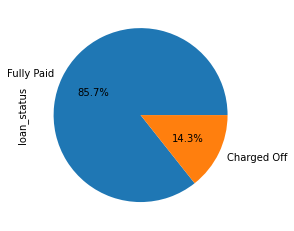

In [72]:
df.loan_status.value_counts().plot.pie(autopct="%.1f%%");

In [73]:
numerical = ['loan_amnt','installment','annual_inc','int_rate_percent','dti']
df[numerical].describe()    #statistical summary of numeric variables

,loan_amnt,installment,annual_inc,int_rate_percent,dti
count,36847.000000,36847.000000,3.684700e+04,36847.000000,36847.000000
mean,11141.327652,324.694599,6.940448e+04,11.988346,13.330449
std,7369.988994,208.886154,6.402747e+04,3.702091,6.651565
min,500.000000,16.080000,4.000000e+03,5.420000,0.000000
25%,5500.000000,167.565000,4.100400e+04,8.940000,8.210000
50%,10000.000000,280.000000,6.000000e+04,11.860000,13.420000
75%,15000.000000,428.975000,8.300000e+04,14.520000,18.590000
max,35000.000000,1305.190000,6.000000e+06,24.400000,29.990000


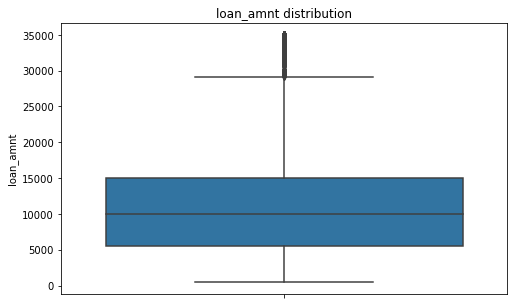

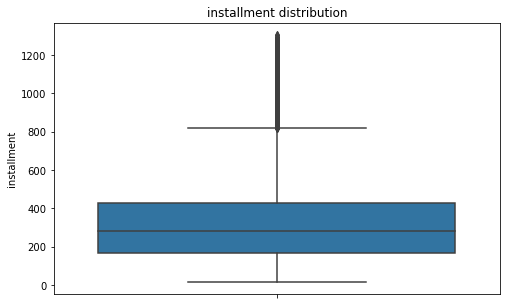

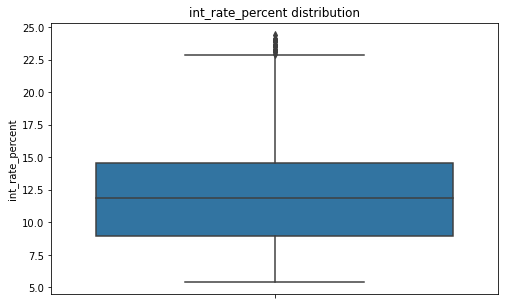

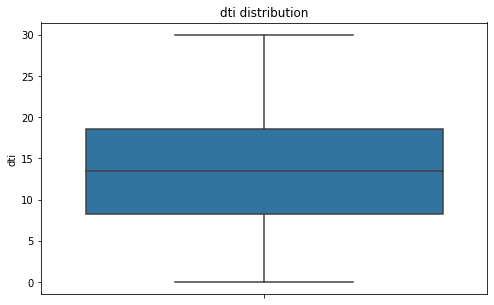

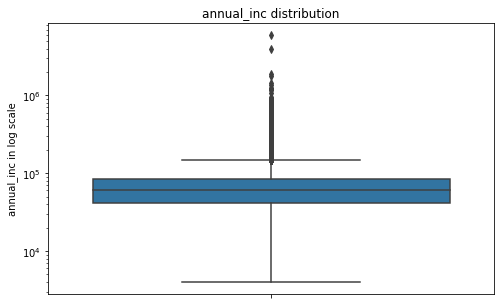

In [74]:
box_plot("loan_amnt")
box_plot('installment')
box_plot('int_rate_percent')
box_plot('dti')
box_plot("annual_inc",y_log=True)

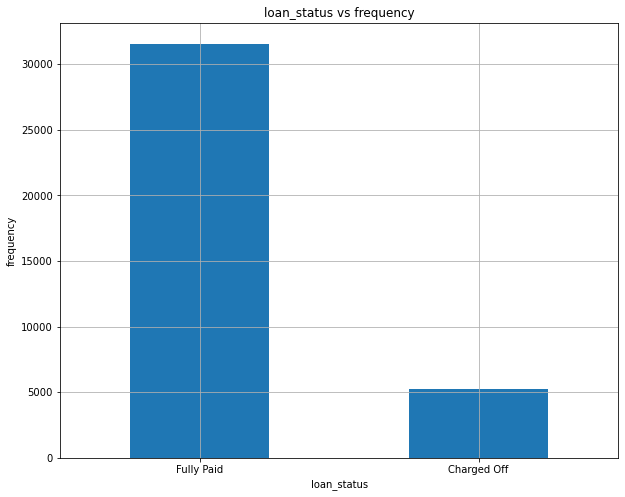

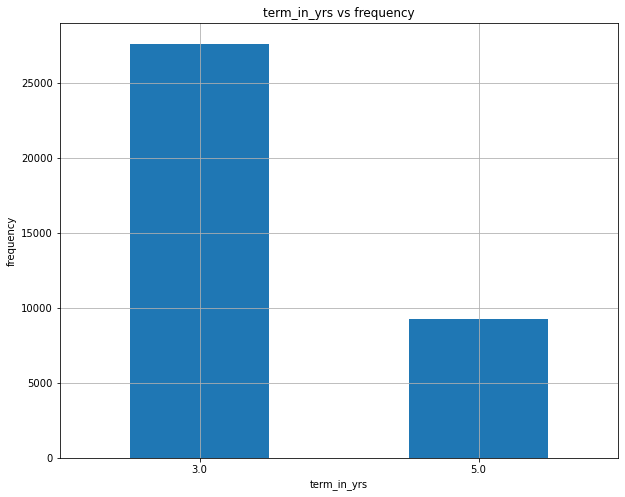

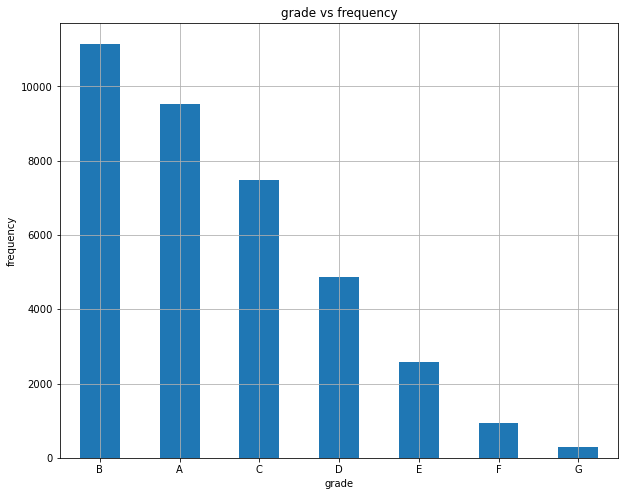

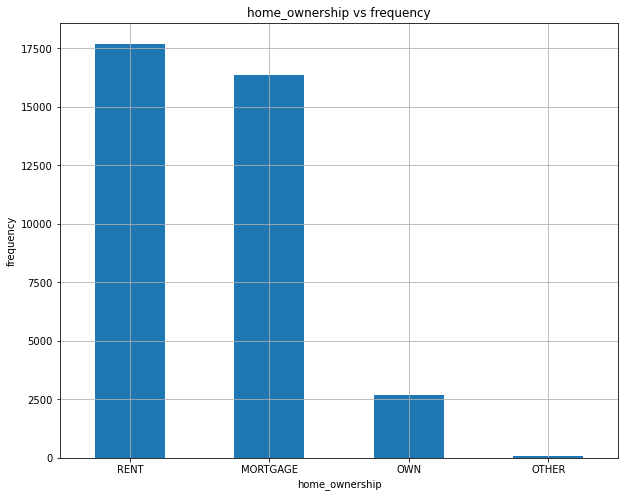

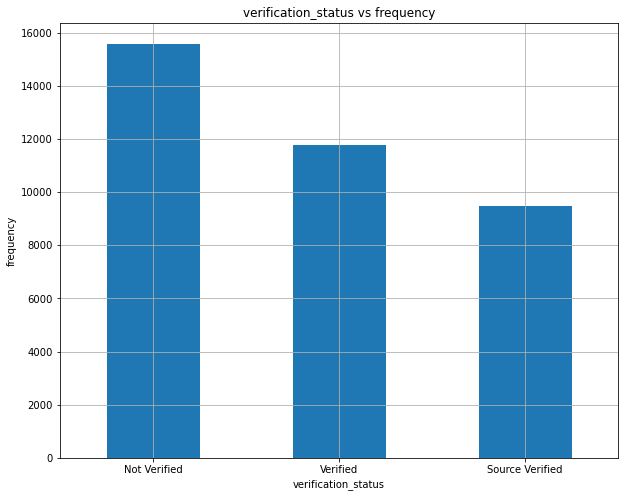

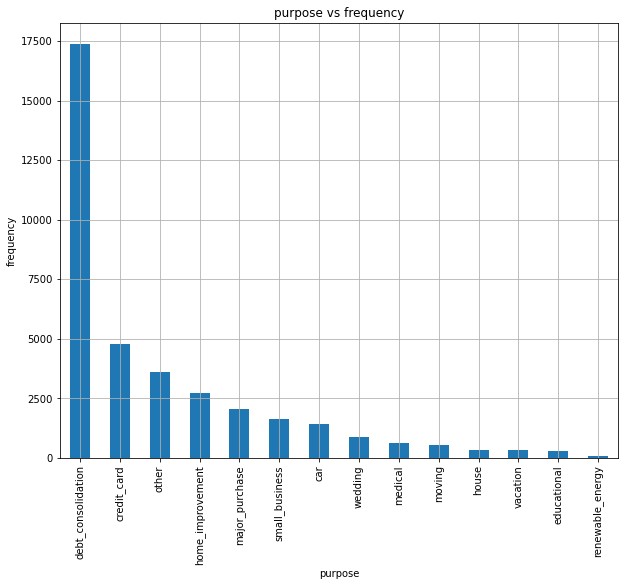

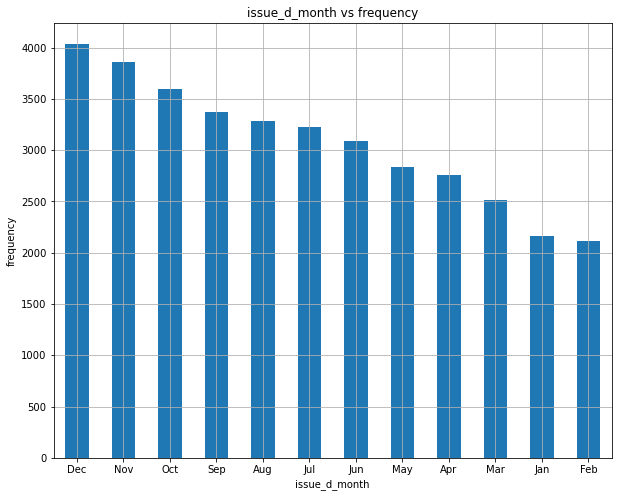

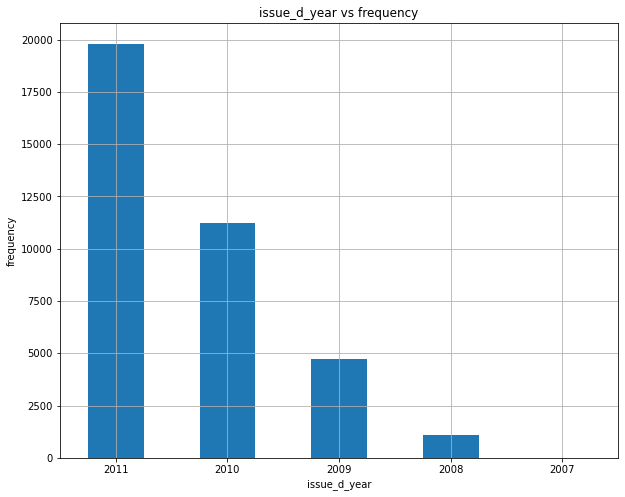

In [75]:
categorical_plot("loan_status")
categorical_plot('term_in_yrs')
categorical_plot('grade')
categorical_plot("home_ownership")
categorical_plot("verification_status")
categorical_plot('purpose',xticks=1)
categorical_plot('issue_d_month')
categorical_plot('issue_d_year')

C:\J3\Softwares\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


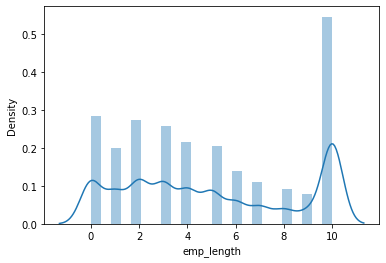

In [76]:
sns.distplot(df.emp_length)
plt.show()

## Segmented univariate analysis

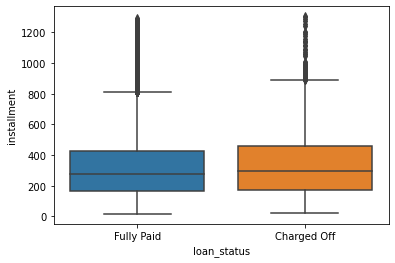

In [77]:
sns.boxplot(x = 'loan_status', y = 'installment', data = df)
plt.show()

* approximately same median value of installment for each the loan status.

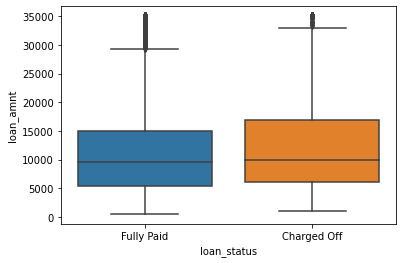

In [78]:
sns.boxplot(x = 'loan_status', y = 'loan_amnt', data = df)
plt.show()

* approximately same median value of loan amount for each the loan status.

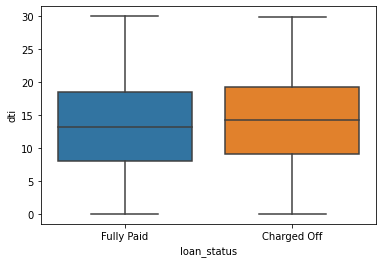

In [79]:
sns.boxplot(x = 'loan_status', y = 'dti', data = df)
plt.show()

* approximately same median value of dti for each the loan status.

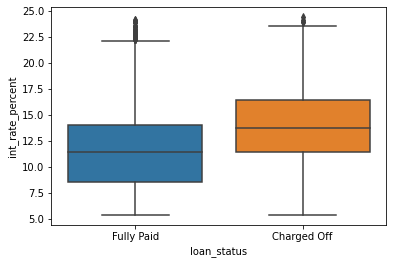

In [80]:
sns.boxplot(x = 'loan_status', y = 'int_rate_percent', data = df)
plt.show()

#### Inference:
* median value of interest rate is higher for charged off than fully paid.

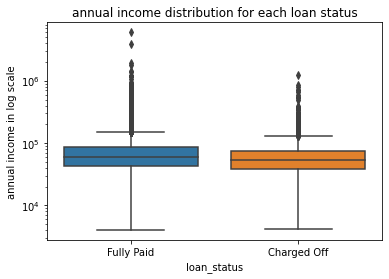

In [81]:
sns.boxplot(x = 'loan_status', y = 'annual_inc', data = df)
plt.yscale('log')
plt.ylabel('annual income in log scale')
plt.title('annual income distribution for each loan status')
plt.show()

* approximately same median value of annual income for each the loan status.

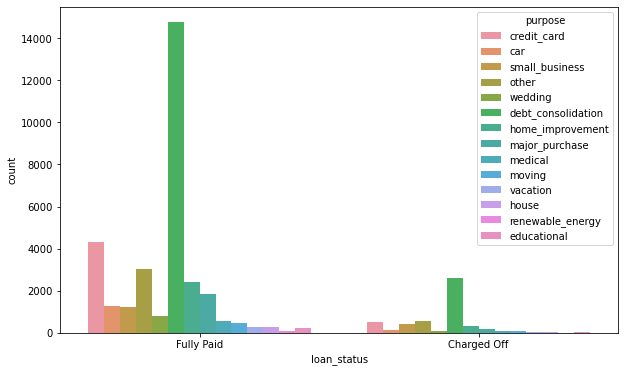

In [82]:
plt.figure(figsize=[10,6])
sns.countplot(x='loan_status', hue = 'purpose',data=df)
plt.show()

* debt consolidation has highest count for both loan statuses.

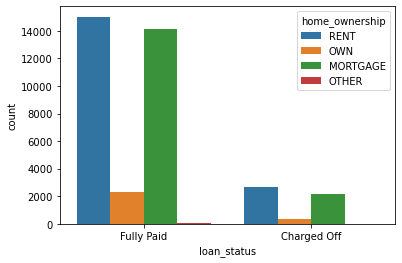

In [83]:
sns.countplot(x='loan_status', hue = 'home_ownership',data=df)
plt.show()

count of customers with home ownership as 'rent' and 'mortage' is high as compared to other categories.

## Binning
* Binning numeric data into categorical data to search any hidden patrterns

#### Here we have decided to bin data into quantiles so that each bin has approximately equal amount of data so the comparison would be more fair.

In [84]:
#binning loan_amt

In [85]:
pd.qcut(df['loan_amnt'], q=4).value_counts()

(5500.0, 10000.0]     11678
(499.999, 5500.0]      9379
(15000.0, 35000.0]     8355
(10000.0, 15000.0]     7435
Name: loan_amnt, dtype: int64

In [86]:
loan_amt_bins_labels = ['<5.5k', '5.5-10k', '10-15k','>15k']
df['loan_amt_range']=pd.qcut(df['loan_amnt'], q=4, labels=loan_amt_bins_labels)

In [87]:
#binning emp_length

In [88]:
pd.qcut(df['emp_length'], q=4).value_counts()

(-0.001, 2.0]    11625
(4.0, 9.0]        9605
(9.0, 10.0]       8369
(2.0, 4.0]        7248
Name: emp_length, dtype: int64

In [89]:
emp_length_bins_labels = ['<2 yrs','2-4 yrs','4-9 yrs','>9 yrs']
df['emp_length_range']=pd.qcut(df['emp_length'], q=4, labels=emp_length_bins_labels)

In [90]:
#binning annual_inc

In [91]:
pd.qcut(df['annual_inc'], q=4).value_counts()

(41004.0, 60000.0]      10517
(3999.999, 41004.0]      9224
(83000.0, 6000000.0]     9183
(60000.0, 83000.0]       7923
Name: annual_inc, dtype: int64

In [92]:
annual_inc_bins_labels = ['<41k', '41-60k', '60k-83k','>83k']
df['annual_inc_range']=pd.qcut(df['annual_inc'], q=4, labels=annual_inc_bins_labels)

In [93]:
#binning dti

In [94]:
pd.qcut(df['dti'], q=6).value_counts()

(-0.001, 6.14]    6151
(13.42, 16.75]    6148
(6.14, 10.04]     6144
(20.53, 29.99]    6137
(16.75, 20.53]    6136
(10.04, 13.42]    6131
Name: dti, dtype: int64

In [95]:
dti_bins_labels = ['0-6','6-10','10-13','13-17','17-21','21-30']
df['dti_range']=pd.qcut(df['dti'], q=6, labels=dti_bins_labels)

In [96]:
#binning int_rate_percent

In [97]:
pd.qcut(df['int_rate_percent'], q=4).value_counts()

(8.94, 11.86]     9538
(5.419, 8.94]     9258
(14.52, 24.4]     9212
(11.86, 14.52]    8839
Name: int_rate_percent, dtype: int64

In [98]:
int_rate_percent_bins_labels = ['5-9','9-12','12-15','15-25']
df['int_rate_percent_range']=pd.qcut(df['int_rate_percent'], q=4,labels=int_rate_percent_bins_labels)

In [99]:
#binning installment

In [100]:
pd.qcut(df['installment'], q=4).value_counts()

(167.565, 280.0]                 9219
(428.975, 1305.19]               9212
(16.078999999999997, 167.565]    9212
(280.0, 428.975]                 9204
Name: installment, dtype: int64

In [101]:
installment_bins_labels = ['<168$','168-280$','280-429$','>429$']
df['installment_range']=pd.qcut(df['installment'], q=4,labels=installment_bins_labels)

In [102]:
#binning open_acc

In [103]:
pd.qcut(df['open_acc'], q=3).value_counts()

(1.999, 7.0]    14441
(7.0, 11.0]     12655
(11.0, 44.0]     9751
Name: open_acc, dtype: int64

In [104]:
open_acc_bins_labels = ['<7','7-11','11-44']
df['open_acc_range']=pd.qcut(df['open_acc'], q=3,labels=open_acc_bins_labels)

In [105]:
#binning earliest_cr_line_year

In [106]:
pd.qcut(df['earliest_cr_line_year'], q=4).value_counts()

(1945.999, 1994.0]    10929
(1994.0, 1998.0]       9066
(2001.0, 2008.0]       8621
(1998.0, 2001.0]       8231
Name: earliest_cr_line_year, dtype: int64

In [107]:
earliest_cr_line_year_bins_labels = ['1946-1994','1994-1998','1998-2001','2001-2008']
df['earliest_cr_line_year_range']=pd.qcut(df['earliest_cr_line_year'], q=4,labels=earliest_cr_line_year_bins_labels)

# Bivariate analysis
* here we will be comparing default rate across varios categories

### ordered categorical variables:

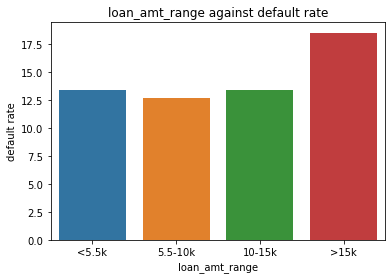

In [108]:
default_rate_barplot('loan_amt_range')
plt.show()

#### inference:
* Default rate is maximum for loan amount >15k. 
* Loan amount can be used as indicator of loan default.

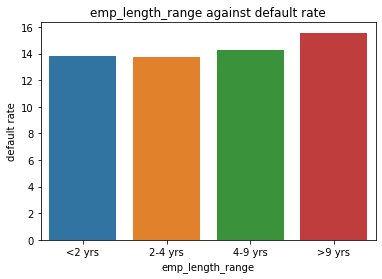

In [109]:
default_rate_barplot('emp_length_range')
plt.show()

#### inference:
* Approximately equal Default rate
* emp_length can not be used as clear indicator of loan default.

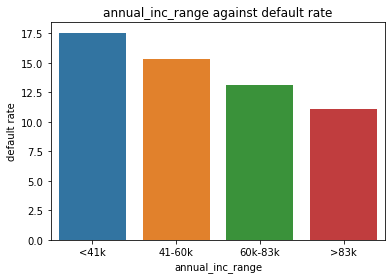

In [110]:
default_rate_barplot('annual_inc_range')
plt.show()

#### inference:
* As annual income is increasing default rate is decrasing.
* annual_inc can be used as indicator of loan default.

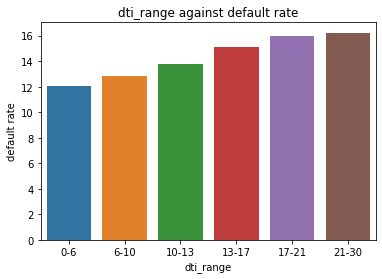

In [111]:
default_rate_barplot('dti_range')
plt.show()

#### inference:
* As dti is increasing default rate is also increasing.
* dti can be used as indicator of loan default.

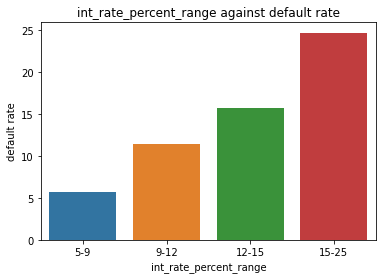

In [112]:
default_rate_barplot('int_rate_percent_range')
plt.show()

#### inference:
* As int rate is increasing default rate is also increasing.
* int rate can be used as indicator of loan default.

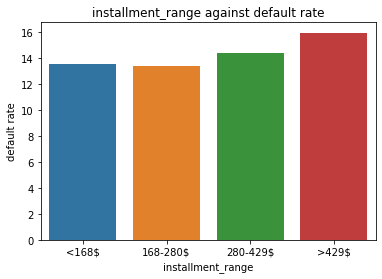

In [113]:
default_rate_barplot('installment_range')
plt.show()

#### inference:
* As installment range is increasing default rate is also increasing.
* installment can be used as indicator of loan default.

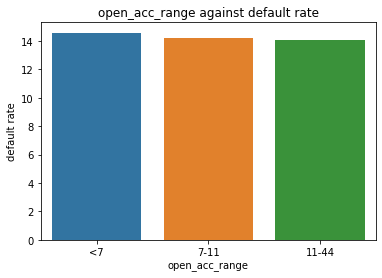

In [114]:
default_rate_barplot('open_acc_range')
plt.show()

#### inference:
* Approximately equal Default rate
* open_acc can not be used as clear indicator of loan default.

In [115]:
df.term_in_yrs.value_counts()  #checking number of values in each bin

3.0    27590
5.0     9257
Name: term_in_yrs, dtype: int64

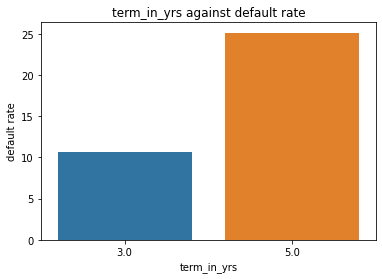

In [116]:
default_rate_barplot('term_in_yrs')
plt.show()

#### inference:
* Default rate is far greater for 5 yrs term than a 3 yrs term.
* term can be used as indicator of loan default.

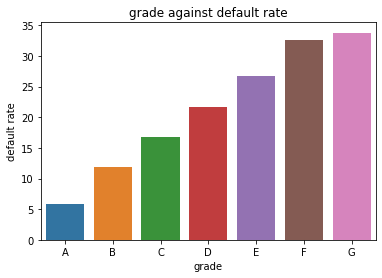

In [117]:
default_rate_barplot('grade')
plt.show()

#### inference:
* As grade moves from A to G, default rate is also increasing.
* Grade can be used as indicator of loan default.

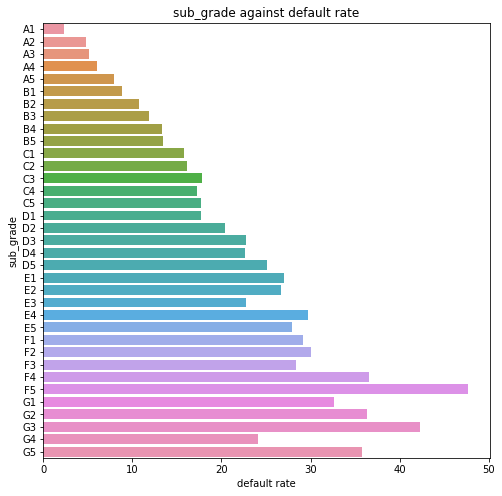

In [118]:
plt.figure(figsize=[8,8])
default_rate_barplot('sub_grade',orient='h')
plt.show()

#### inference:
* As sub grade moves from A1 to G5, default rate is also generally increasing.
* Sub Grade can be used as indicator of loan default.

In [119]:
df.issue_d_month.value_counts()       #checking number of values in each bin

Dec    4037
Nov    3855
Oct    3591
Sep    3374
Aug    3288
Jul    3223
Jun    3093
May    2836
Apr    2756
Mar    2517
Jan    2166
Feb    2111
Name: issue_d_month, dtype: int64

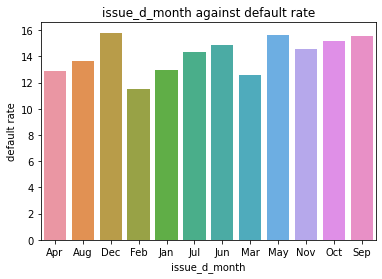

In [120]:
default_rate_barplot('issue_d_month')
plt.show()

#### inference:
* default rate is maximum for month of december,may.
* It may be due to people would spend more on festiv season such as christmas and memorial day which takes place in month of december and may.
* Issue month can be used as indicator of default.

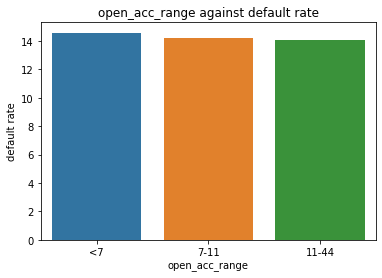

In [121]:
default_rate_barplot('open_acc_range')
plt.show()

#### inference:
* Approx. constant default rate.
* number of Open account can not be used as indicator of loan default 

In [122]:
df.inq_last_6mths.value_counts()

0    17877
1    10191
2     5405
3     2843
4      294
5      136
6       57
7       32
8       12
Name: inq_last_6mths, dtype: int64

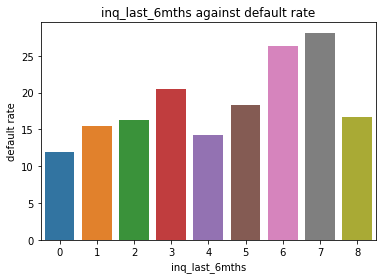

In [123]:
default_rate_barplot('inq_last_6mths')
plt.show()

#### inference:
* No particular trend obsereved for default rate.
* number of inq_last_6mths can not be used as indicator of loan default

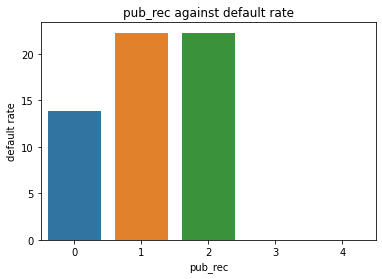

In [124]:
default_rate_barplot('pub_rec')
plt.show()

#### inference:
* No particular trend obsereved for default rate.
* number of pub_rec can not be used as indicator of loan default

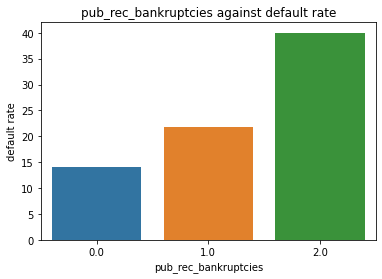

In [125]:
default_rate_barplot('pub_rec_bankruptcies')
plt.show()

#### inference:
* trend obsereved for default rate.
* number of pub_rec_bankruptcies can be used as indicator of loan default

In [126]:
df.issue_d_year.value_counts()      #checking number of values in each bin

2011    19801
2010    11214
2009     4713
2008     1112
2007        7
Name: issue_d_year, dtype: int64

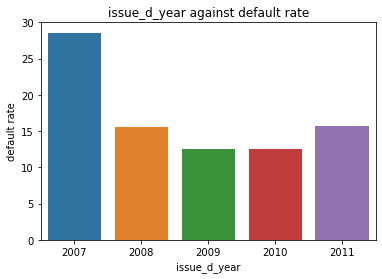

In [127]:
default_rate_barplot('issue_d_year')
plt.show()

#### inference:
* 2007 year has very low number of observations to confirm that it has higher default rate. Also there is no particular trend of default rate for other categories.
* issue year can not be used as default indicator.

In [128]:
df.earliest_cr_line_month.value_counts()

Oct    3804
Dec    3758
Nov    3651
Sep    3344
Jan    3205
Aug    3083
Jul    2830
Jun    2734
May    2691
Feb    2644
Mar    2571
Apr    2532
Name: earliest_cr_line_month, dtype: int64

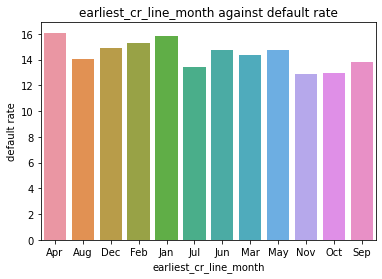

In [129]:
default_rate_barplot('earliest_cr_line_month')
plt.show()

#### inference:
* No particular trend obsereved.
* Can not be surely used as default indicator.

In [130]:
df.earliest_cr_line_year_range.value_counts()

1946-1994    10929
1994-1998     9066
2001-2008     8621
1998-2001     8231
Name: earliest_cr_line_year_range, dtype: int64

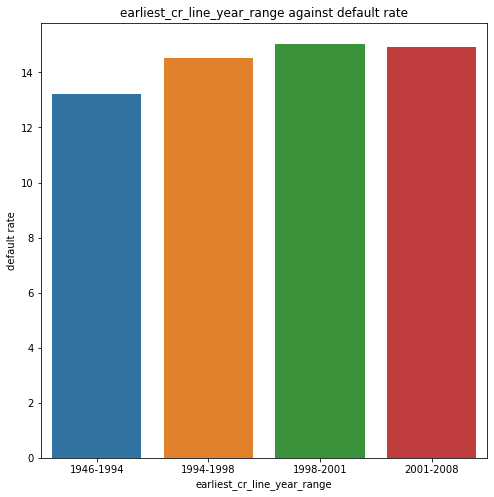

In [131]:
plt.figure(figsize=[8,8])
default_rate_barplot('earliest_cr_line_year_range')
plt.show()

#### inference:
* We are observing slightly increasing default rate as we move from 40s to 2010s
* since the variation is very little, we will not consider it as a driving factor.

### unordered categorical:

In [132]:
df.home_ownership.value_counts()     #checking number of values in each bin

RENT        17698
MORTGAGE    16343
OWN          2708
OTHER          98
Name: home_ownership, dtype: int64

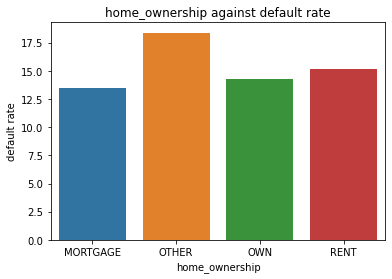

In [133]:
default_rate_barplot('home_ownership')
plt.show()

#### inference:
* As 'other' category conatains very low number of values we can not surely confirm the trend of default rate here.
* home ownership can not be used as clear indicator of loan default.

In [134]:
df.verification_status.value_counts()   #checking number of values in each bin

Not Verified       15582
Verified           11771
Source Verified     9494
Name: verification_status, dtype: int64

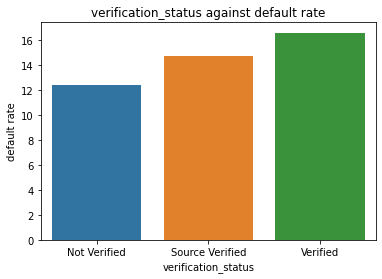

In [135]:
default_rate_barplot('verification_status')
plt.show()

#### inference:
* Default rate is obsereved to be maximum for verified category and least for not verified. Which is a bit contradicting to general thought of clients with 'not verified' income would be more likely default and the ones with verified have more credibility and thus less likely to default.
* Perhaps verification criterion/process is flawed.
* further hypothesis testing would be a better choice than claiming it as a driving factor.

In [136]:
df.purpose.value_counts()

debt_consolidation    17384
credit_card            4801
other                  3608
home_improvement       2737
major_purchase         2061
small_business         1657
car                    1431
wedding                 894
medical                 647
moving                  543
house                   349
vacation                342
educational             299
renewable_energy         94
Name: purpose, dtype: int64

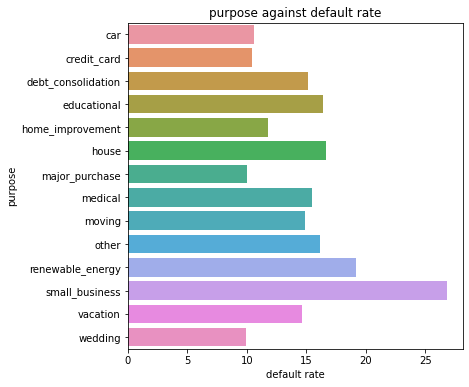

In [137]:
plt.figure(figsize=[6,6])
default_rate_barplot('purpose',orient='h')
plt.show()

#### inference:
* Default rate is maximum for small business category.
* purpose can be used as indicator of loan default.

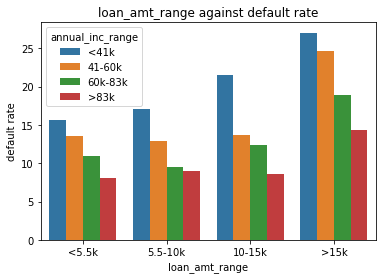

In [138]:
default_rate_barplot(attribute='loan_amt_range',level_2='annual_inc_range')
plt.show()

#### inference:
* for a given range of loan amount, default rate is maximum for clients with annual income <41k

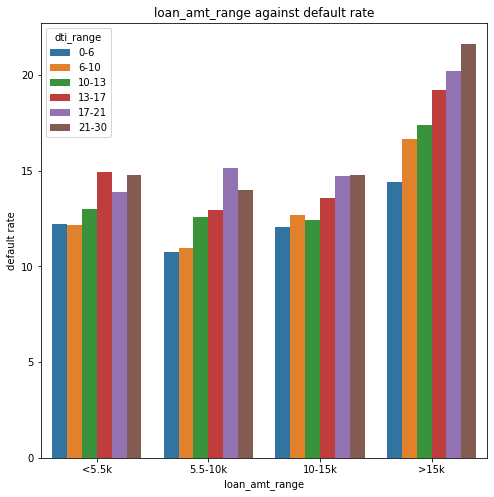

In [139]:
plt.figure(figsize=[8,8])
default_rate_barplot(attribute='loan_amt_range',level_2='dti_range')
plt.show()

#### inference:
* for a '>15k' range of loan amount, default rate is considerably high for clients with dti 17 onwards.

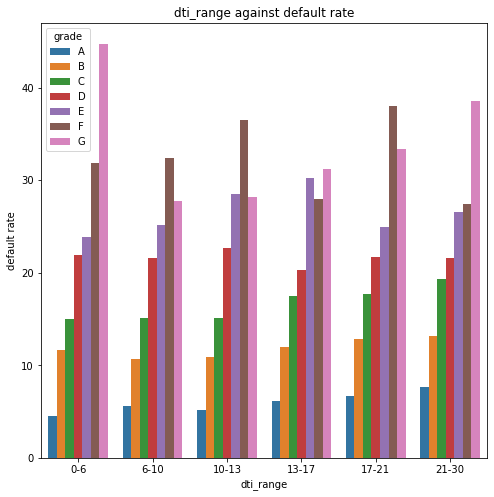

In [140]:
plt.figure(figsize=[8,8])
default_rate_barplot(attribute='dti_range',level_2='grade')
plt.show()

#### inference:
* for every dti range, default rate generally increases as grade moves from A to G.

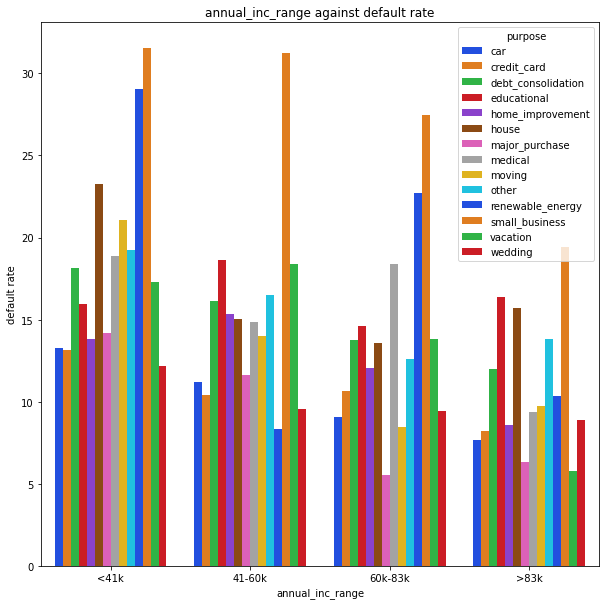

In [141]:
plt.figure(figsize=[10,10])
default_rate_barplot(attribute='annual_inc_range',level_2='purpose',col_palette='bright')
plt.show()

#### inference:
* For every income range, default rate is maximum for small business purpose.
* it is followed by renewable energy category for the income range '<41k' and '60-83k'

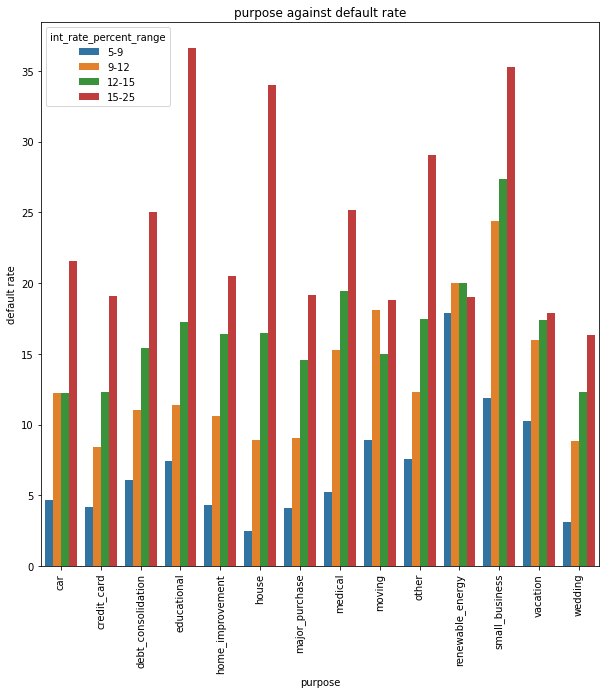

In [142]:
plt.figure(figsize=[10,10])
default_rate_barplot(attribute='purpose',level_2='int_rate_percent_range',rot=90)
plt.show()

 #### inference:
 * For almost every purpose, higher interest rates have higher default rate.

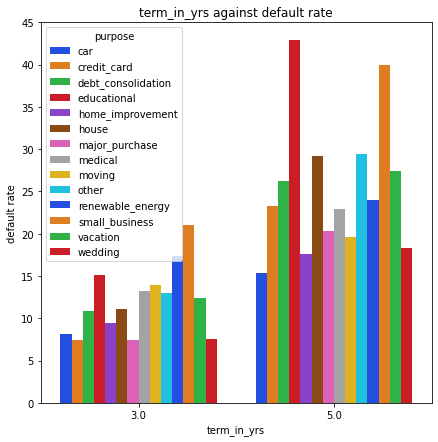

In [143]:
plt.figure(figsize=[7,7])
default_rate_barplot(attribute='term_in_yrs',level_2='purpose',col_palette='bright')
plt.show()

#### inference:
* for 3 yrs term, default rate is higher when loan purpose is small buisness.
* for 5 yrs term, efault rate is higher when loan purpose is small buisness and edjucational.

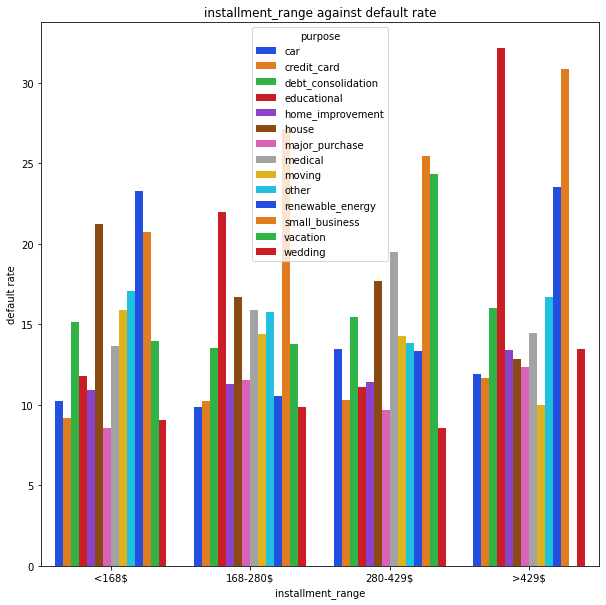

In [144]:
plt.figure(figsize=[10,10])
default_rate_barplot(attribute='installment_range',level_2='purpose',col_palette='bright')
plt.show()

#### inference:
* for installment range <168 dollars, default rate is higher renewable energy,house and small business.
* for installment range 168-280 dollars and >429 dollars,default rate is higher for education and small business.
* for installment range 280-429 dollars ,default rate is higher for vacation and small business.

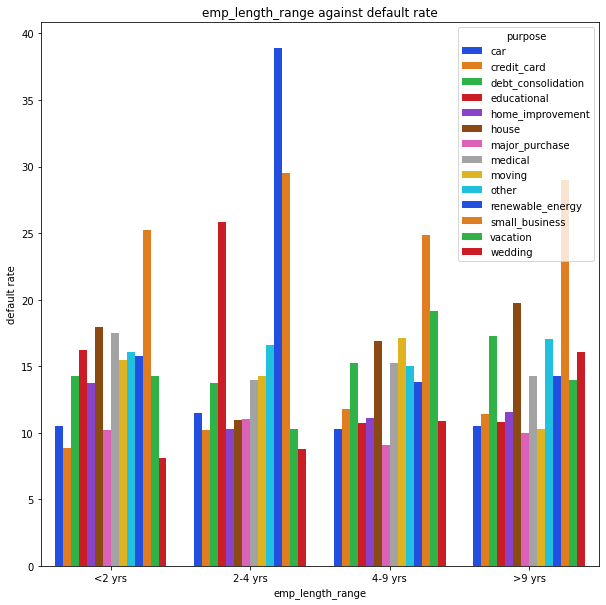

In [145]:
plt.figure(figsize=[10,10])
default_rate_barplot(attribute='emp_length_range',level_2='purpose',col_palette='bright')
plt.show()

* for all employee lenth ranges, default rate is maximum for small buisness purpose except for 2-4yrs range for which it trails after the renewable energy category.

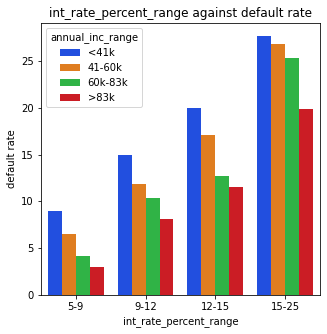

In [146]:
plt.figure(figsize=[5,5])
default_rate_barplot(attribute='int_rate_percent_range',level_2='annual_inc_range',col_palette='bright')
plt.show()

* for each interest rate range,default rate is maximum for lowest annual income.

# Final Conclusion
* Default rate is maximum for purpose category ‘small business’. Which is followed by ‘renewable energy’ and educational category.
* As sub grade moves from A to G (A1 to G5), default rate is also generally increasing. As per business criterion threshold grade can be set such that for applicant with grade above this loan is rejected.
* As  term duration increases default rate also goes up. We can reduce the damage by charging suitable higher interest rate for longer terms.
* Loan amount is also an indicator of default rate. Default rate is higher for higher loan amount. It is maximum for loan amount >15k. 
* Default rate increases with decrease in annual income. Loans should be sanctioned very cautiously for those with annual income <41k.
* DTI is also a very strong indicator of default. By setting threshold of dti value according to business objective, we can avoid credit loss.
* Installment amount, interest rate are also indictors of defaulters as they are positively correlated.
* To avoid business loss, if we are approving risky loans with much higher interest rate in order to reduce credit loss incase of default, then also we are increasing chances of default. So interest rate should be finely tuned.
*Applicants with two or even one public record bankruptcies should be denied of loan.